In [12]:
%matplotlib notebook
from utils.dataloader import PascalVOCDataset
from utils.dataloader import myimshow
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
import numpy as np
from matplotlib import pyplot as plt
from utils.PositionSensitiveScoreMap import PositionSensitiveScoreMap

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [13]:
dataset_root_dir = "/datasets/ee285f-public/PascalVOC2012/"

#Creating training and validation sets. Go to utils/dataloader.py for info on important PascalVOCDataset arguments & attributes
train_set = PascalVOCDataset(dataset_root_dir, mode= 'train')
test_set = PascalVOCDataset(dataset_root_dir, mode= 'val')

#Create dataloaders
B = 1
train_loader = td.DataLoader(train_set, batch_size = B, pin_memory = True, shuffle = True)
test_loader = td.DataLoader(test_set, batch_size = B, pin_memory = True)

<IPython.core.display.Javascript object>


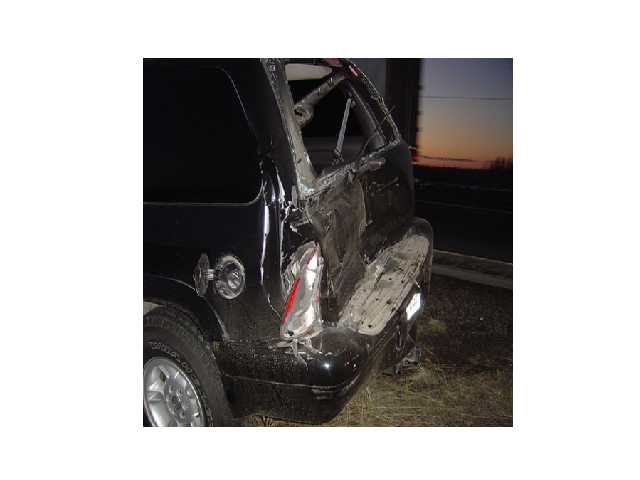

Bounding box corners tensor([[  1,   1, 520, 410]])


In [14]:
#Training set image demo
fig, ax = plt.subplots()
x, bbox, bbox_labels, scale = train_set.__getitem__(15)
h = myimshow(x, ax)

print("Bounding box corners", bbox)

In [15]:
tensor_im = x.to(device).unsqueeze(0)

In [16]:
#before running, $cd Multi-Object-Detection/model/utils/nms
#then            $python3 build.py build_ext --inplace

from model.region_proposal_network import RegionProposalNetwork
from model.resnet101extractor import Resnet101Extractor
from model.rfcn_resnet101 import Resnet101RoIHead
from model.rfcn_resnet101 import RFCNResnet101

n_fg_class = 20
feat_stride = 520//16
extractor = Resnet101Extractor().to(device)
rpn = RegionProposalNetwork(in_channels=1024, mid_channels = 1024).to(device)
head = Resnet101RoIHead( #Main class to change
            n_class=n_fg_class + 1,
            roi_size=7,
            spatial_scale=(1. / feat_stride)
        ).to(device)

rfcn = RFCNResnet101().to(device)

/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/model/rfcn_resnet101.py:82: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.cls_layer.weight.data, 0.0, 0.01)
/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/model/rfcn_resnet101.py:86: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.reg_layer.weight.data, 0.0, 0.01)


In [17]:
out = rfcn(tensor_im)

/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/utils/PositionSensitiveScoreMap.py:65: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = self.softmax(self.AvgPool(pooling_track.float()))


In [18]:
from trainer import FasterRCNNTrainer
trainer = FasterRCNNTrainer(rfcn).to(device)

In [19]:
train_loader = td.DataLoader(train_set, batch_size=1, pin_memory = True, shuffle = True)
test_loader  = td.DataLoader(test_set, batch_size=1, pin_memory = True, shuffle = False)

In [22]:
img, bboxes, lbls, scale = next(iter(train_loader))
img = img.to(device)
bboxes = bboxes.to(device)
lbls = lbls.to(device)
scale = scale.item()
trainer.train_step(img, bboxes, lbls, scale)

(37,)
<class 'numpy.ndarray'>
[7 7 7 7 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/utils/PositionSensitiveScoreMap.py:65: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = self.softmax(self.AvgPool(pooling_track.float()))


LossTuple(rpn_loc_loss=tensor(0.0879, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(7.1622, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(0.2500, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(3.0534, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(10.5535, device='cuda:0', grad_fn=<AddBackward0>))
tensor(10.5535, device='cuda:0', grad_fn=<AddBackward0>)
<class 'torch.Tensor'>


LossTuple(rpn_loc_loss=tensor(0.0879, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(7.1622, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(0.2500, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(3.0534, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(10.5535, device='cuda:0', grad_fn=<AddBackward0>))

In [10]:
img, bboxes, lbls, scale = next(iter(train_loader))

In [11]:
feature_map = extractor(tensor_im)
rpn_locs, rpn_scores, rois, roi_indices, anchor = rpn.forward(feature_map,(520,520))
#print(rois)
#rpn_locs, rpn_scores, rois, roi_indices, anchor = rpn.forward(feature_map,feature_map.shape[2:])
#print(rois)
cls_layer = nn.Conv2d(1024,21*7*7, [1,1], padding=0, stride=1).cuda()
#nn.init.kaiming_normal_(cls_layer.weight.data)

cls_conv_out = cls_layer(feature_map)
PSSM =PositionSensitiveScoreMap()
#print(PSSM)
scores = PSSM(cls_conv_out,rois)
print(rois.shape[0])
print(scores.sum(2))

72


/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/utils/PositionSensitiveScoreMap.py:65: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = self.softmax(self.AvgPool(pooling_track.float()))


RuntimeError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [18]:
rfcn.cuda()

RFCNResnet101(
  (extractor): Resnet101Extractor(
    (RN_base): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (3): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (downsample): Se

AttributeError: 'generator' object has no attribute 'cuda'